# Notebook : Approximations de modèles opaques par modèles interprétables

In [2]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Pour RiskSLIM approché
from imodels import SLIMClassifier

# Pour LIME
import lime
import lime.lime_tabular

## 1. Chargement du dataset

In [ ]:
df = pd.read_csv('../data/compas-scores.csv')
df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,vr_offense_date,vr_charge_desc,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,type_of_assessment,decile_score.1,score_text,screening_date
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,NaN,NaN,Risk of Violence,1,Low,2013-08-14,Risk of Recidivism,1,Low,2013-08-14
1,2,michael ryan,michael,ryan,2014-12-31,Male,1985-02-06,31,25 - 45,Caucasian,...,NaN,NaN,Risk of Violence,2,Low,2014-12-31,Risk of Recidivism,5,Medium,2014-12-31
2,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,2013-07-05,Felony Battery (Dom Strang),Risk of Violence,1,Low,2013-01-27,Risk of Recidivism,3,Low,2013-01-27
3,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,NaN,NaN,Risk of Violence,3,Low,2013-04-14,Risk of Recidivism,4,Low,2013-04-14
4,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,NaN,NaN,Risk of Violence,6,Medium,2013-01-13,Risk of Recidivism,8,High,2013-01-13


## 2. Sélection des features et target

In [4]:
# Exemple de features simples
features = ['sex', 'age', 'race', 'priors_count', 'c_charge_degree']
target = 'is_recid'

df = df.dropna(subset=features + [target])
X = df[features]
y = df[target]

## 3. Split train/test

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

## 4. Prétraitement et pipeline opaque

In [6]:
numeric_features = ['age', 'priors_count']
categorical_features = ['sex', 'race', 'c_charge_degree']

numeric_transformer = Pipeline([
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

pipeline = Pipeline([
    ('preproc', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Entraînement
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'priors_count']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sex', 'race',
                                                   'c_charge_degree'])])),
                ('clf', RandomForestClassifier(random_state=42))])

## 5. Évaluation du modèle opaque

In [7]:
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.95      1.00      0.98       216
           0       0.71      0.78      0.75      2201
           1       0.46      0.37      0.41      1111

    accuracy                           0.67      3528
   macro avg       0.71      0.72      0.71      3528
weighted avg       0.65      0.67      0.65      3528



## 6. Importances des caractéristiques

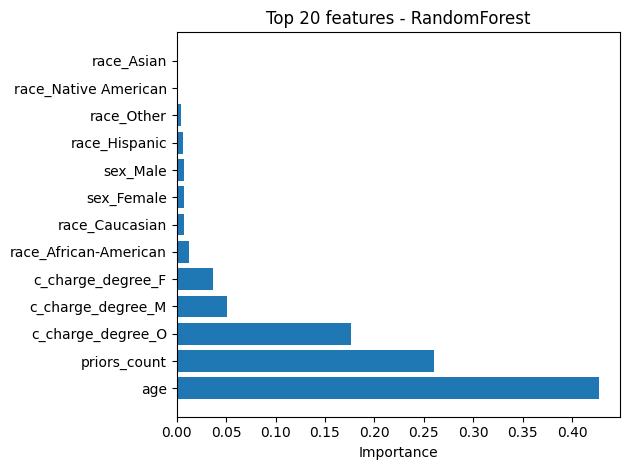

In [8]:
# Récupérer importances du RandomForest
rf = pipeline.named_steps['clf']
feat_names = (
    numeric_features + 
    list(pipeline.named_steps['preproc']
         .named_transformers_['cat']
         .named_steps['onehot']
         .get_feature_names_out(categorical_features))
)
importances = rf.feature_importances_
top_idx = np.argsort(importances)[-20:][::-1]

plt.figure()
plt.barh([feat_names[i] for i in top_idx], importances[top_idx])
plt.xlabel("Importance")
plt.title("Top 20 features - RandomForest")
plt.tight_layout()
plt.show()

## 7. Sauvegarde de la pipeline

In [10]:
joblib.dump(pipeline, '../models/pipeline_compas_rf.pkl')

['../models/pipeline_compas_rf.pkl']